# Noisy handwriting, deep learning and auto-encoders


***
***
# **WORK IN PROGRESS**
***
***


In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original", data_home='./data/')  

X, y = mnist.data / 255., mnist.target

print("Dimensions of X:", X.shape)
print("Dimensions of y:", y.shape)

Dimensions of X: (70000, 784)
Dimensions of y: (70000,)


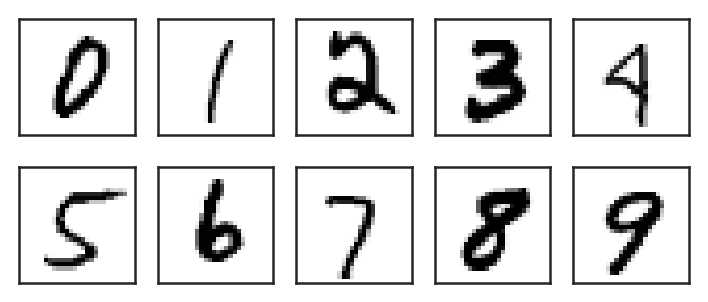

In [6]:
# As you can see, the 70k images have 784 pixels, which is 28**2, and that's not a coincidence:
imsize = 28

# Look at a random example of every number. Run the cell several times to see several examples. 
plt.figure(figsize=(12, 5))
for target in range(10):
    thisone = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(X[thisone]), [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

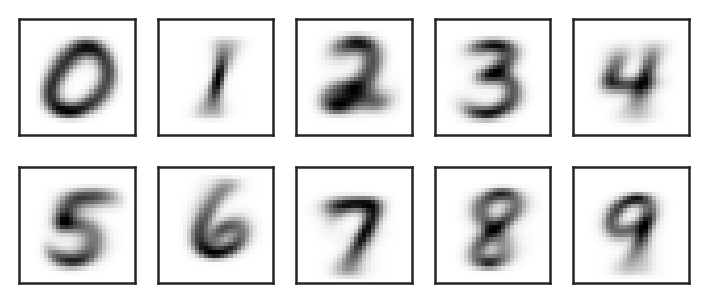

In [7]:
# We can also generate the mean image for every digit.
# This in fact comes close to the model we are going to train!
plt.figure(figsize=(12, 5))
for target in range(10):
    number = np.reshape( X[np.where(y==target)].mean(axis=0) , [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

In [5]:
# A rename for clarity
labels = y
features = X

In [8]:
# Splitting training from testing data
from sklearn.model_selection import train_test_split

xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)

Score on training set: 0.93 
Score on independent test data: 0.92


In [ ]:
#Initialize and run a logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(xtr, ytr)
print("Score on training set: {0:3.2f} \nScore on independent test data: {1:3.2f}".format(clf.score(xtr, ytr), clf.score(x, y)))

/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


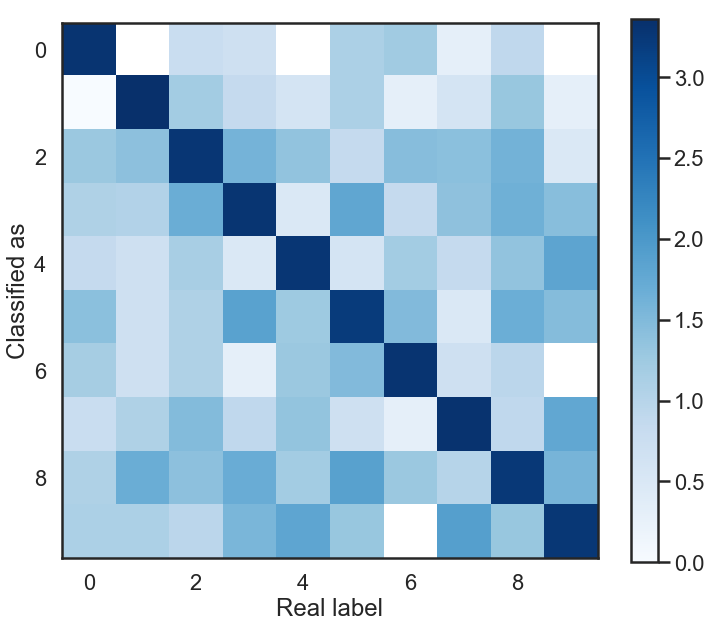

In [15]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar();

In [18]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

mlp.fit(xtr, ytr)
print("Score on independent test data: {0:5.4f}".format(mlp.score(x, y)))

Score on independent test data: 0.9761


In [22]:
mlp_deep = MLPClassifier(hidden_layer_sizes=(500, 200, 50))

mlp_deep.fit(xtr, ytr)
print("Score on independent test data: {0:5.4f}".format(mlp_deep.score(x, y)))

Score on independent test data: 0.9793


In [25]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(500, activation=tf.nn.relu),
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(xtr, ytr, epochs=20)

print("Score on training set: {0:5.4f} \nScore on independent test data: {1:5.4f}".format(model.evaluate(xtr, ytr)[1], model.evaluate(x, y)[1]))

Epoch 1/20
49000/49000 [==============================] - 13s 262us/step - loss: 0.2198 - acc: 0.9340
Epoch 2/20
49000/49000 [==============================] - 13s 261us/step - loss: 0.0904 - acc: 0.9716
Epoch 3/20
49000/49000 [==============================] - 13s 275us/step - loss: 0.0624 - acc: 0.9806
Epoch 4/20
49000/49000 [==============================] - 13s 274us/step - loss: 0.0493 - acc: 0.9841
Epoch 5/20
49000/49000 [==============================] - 14s 276us/step - loss: 0.0362 - acc: 0.9880
Epoch 6/20
49000/49000 [==============================] - 14s 276us/step - loss: 0.0322 - acc: 0.9896
Epoch 7/20
49000/49000 [==============================] - 14s 276us/step - loss: 0.0267 - acc: 0.9914
Epoch 8/20
49000/49000 [==============================] - 16s 325us/step - loss: 0.0234 - acc: 0.9922
Epoch 9/20
49000/49000 [==============================] - 23s 476us/step - loss: 0.0212 - acc: 0.9932
Epoch 10/20
49000/49000 [==============================] - 21s 423us/step - loss: 

## Digits with noise, reconstruction and classification

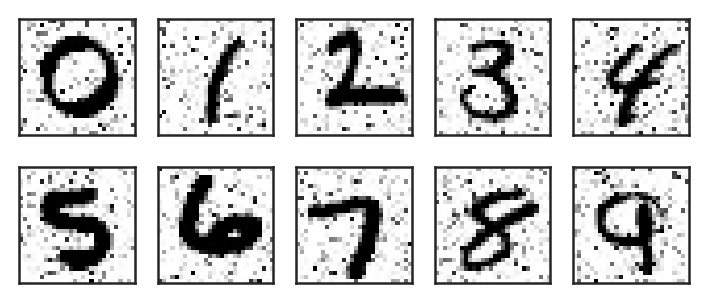

In [10]:
# Let's create some noise, in a separate array to be added to the images
n_pixels = x.size

# As a simple example: the logarithm of the noise is uniformly distributed between -4 and 0:
lognoise = np.random.uniform(-4, 0, n_pixels).reshape(x.shape)
xnoise = x + 10**lognoise

# The array array now possibly runs from (almost) zero to 2, so clip it: 
xnoise = np.clip(xnoise, 0, 1)

# To show some examples
imsize = 28

# Bekijk van elk getal een random voorbeeld. Als je deze cell meerdere keren uitvoert krijg je steeds een nieuwe serie. 
plt.figure(figsize=[12, 5])
for target in range(10):
    this = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(xnoise[this]), [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])
    

In [13]:
# Train an autoencoder on noise-free images and reconstruct the noisy ones.
auto_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
auto_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

auto_encoder.fit(xtr, xtr, epochs=10, batch_size=256)

# Reconstruct the noisy images
reconstructed = auto_encoder.predict(xnoise)


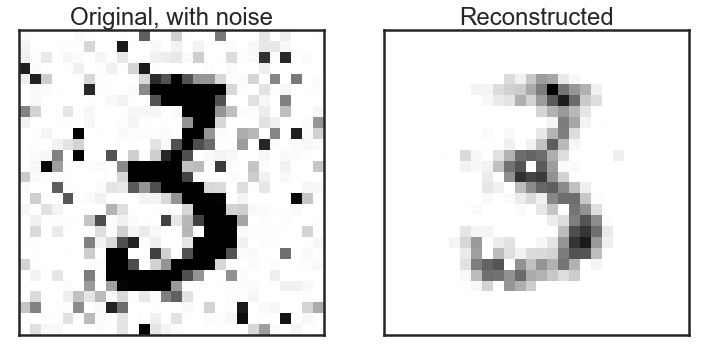

In [21]:
# Compare noisy input to reconstruction
N_im = len(xnoise)
this = np.random.randint(0, N_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(122)
number = np.reshape(reconstructed[this], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Reconstructed")

pp = plt.subplot(121)
number = np.reshape(xnoise[this], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Original, with noise");

In [26]:
# Prediction of the previously trained classifier on the training set, the noisy images and the reconstructed images:
print("Performance on training set:")
print(model.evaluate(xtr, ytr))
print("Performance on noisy digits:")
print(model.evaluate(xnoise, y))
print("Performance of the same network on de-noised digits:")
print(model.evaluate(reconstructed, y))
print("That should show sigificant gains!")


Performance on training set:
49000/49000 [==============================] - 3s 52us/step
[0.009956547827523424, 0.9967959183673469]
Performance on noisy digits:
21000/21000 [==============================] - 1s 64us/step
[0.4131794615338246, 0.8920476190476191]
Performance of the same network on de-noised digits:
21000/21000 [==============================] - 1s 61us/step
[0.259368805285898, 0.941]
That should show sigificant gains!


## To add still:
The fake auto-encoder that goes through a bottleneck of two and predicts the labels, to show all label information can be encoded in two dimensions from the images. Comparison with t-SNE.